In [1]:
import os
from lenscarf import utils_hp
import healpy as hp
import numpy as np

from plancklens import utils
from itfgs.sims import sims_cmbs

from itfgs.params import S4n32 as n32

import os
from os.path import join as opj
import numpy as np
import healpy as hp

import plancklens

from plancklens import utils, qresp, qest, qecl
from plancklens.qcinv import cd_solve
from plancklens.sims import maps, phas
from plancklens.filt import filt_simple, filt_util

from lenscarf import utils_scarf, utils_sims
from lenscarf.iterators import cs_iterator as scarf_iterator, steps
from lenscarf.utils import cli
from lenscarf.utils_hp import gauss_beam, almxfl, alm_copy
from lenscarf.opfilt.opfilt_iso_tt_wl import alm_filter_nlev_wl as alm_filter_tt_wl

from lenspyx.remapping.deflection_029 import deflection
from lenspyx.remapping import utils_geom

import itfgs
from itfgs.sims.sims_postborn import sims_postborn
import itfgs.sims.sims_cmbs as simsit

from lenscarf import n0n1_iterative as n01

import matplotlib.pyplot as plt


In [2]:
def camb_clfile_gradient(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.
    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.
    """
    cols = np.loadtxt(fname).transpose()
    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'pperp', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'pperp', 'te']):
        cls[k][ell[idc]] = cols[i + 1][idc] / w[idc]
    return cls


In [3]:
class sims_delensed(sims_cmbs.sims_cmb_len):
    """Simulations of CMBs each having the same GF postborn + non linear effect deflection kappa
        Args:
            lib_dir: the phases of the CMB maps and the lensed CMBs will be stored there
            lmax_cmb: cmb maps are generated down to this max multipole
            cls_unl: dictionary of unlensed CMB spectra
            dlmax, nside_lens, facres, nbands: lenspyx lensing module parameters
            wcurl: include field rotation map in the lensing deflection (default to False for historical reasons)


        This just redefines the sims_cmbs.sims_cmb_len method to feed the nonlinear kmap
    """
    def __init__(self, lib_dir, lmax_cmb, cls_unl:dict, wcurl = False,
                 dlmax=1024, lmin_dlm = 2, nside_lens=4096, facres=0, nbands=8, cache_plm=True, lib_pha = None, extra_tlm = None, epsilon = 1e-7):

        lmax_plm = lmax_cmb + dlmax
        mmax_plm = lmax_plm

        cmb_cls = {}
        for k in cls_unl.keys():
            if 'p' not in k :
                cmb_cls[k] = np.copy(cls_unl[k][:lmax_cmb + dlmax + 1])
        self.wcurl = wcurl
        self.lmax_plm = lmax_plm
        self.mmax_plm = mmax_plm
        self.cache_plm = cache_plm
        super(sims_delensed, self).__init__(lib_dir,  lmax_cmb, cmb_cls,
                                            dlmax=dlmax, nside_lens=nside_lens, facres=facres, nbands=nbands, lmin_dlm = lmin_dlm, lib_pha = lib_pha, extra_tlm = extra_tlm, epsilon = epsilon)

    def get_sim_kappa(self, idx: int):
        pass

    def get_sim_omega(self, idx: int):
        pass

    def get_sim_tlm(self, idx):
        print("Reading delensed tlm")
        directory = "/Users/omard/Documents/projects/fgcmblensing/foregrounds/websky/"
        return hp.read_alm(directory+f"delensed_in_tlm_{idx}.fits")

In [4]:
case = "websky"

suffixCMB, suffixCMBPhas, suffixLensing, SimsShegalDict, extra_tlm = n32.get_info(case)

print("Working on case", case, "with suffix", suffixCMB, suffixCMBPhas, suffixLensing)

#os.environ['OMP_NUM_THREADS'] = os.environ.get('OMP_NUM_THREADS', '8')

SIMDIR = opj(os.environ['SCRATCH'], 'n32', suffixCMB, 'cmbs')  # This is where the postborn are (or will be saved)
lib_dir_CMB = opj(os.environ['SCRATCH'], 'n32', suffixCMBPhas, 'cmbs') #this is where I store phas, if already computed
TEMP =  opj(os.environ['SCRATCH'], 'n32', suffixLensing, 'lenscarfrecs_delensed')

fgs = 0.

if "websky" in case:
    print("Cosmology for", case)
    cls_path = opj(os.environ['HOME'], 'fgcmblensing', 'input', 'websky')
    cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls_websky.dat'))
    cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls_websky.dat'))
    cls_grad = camb_clfile_gradient(opj(cls_path, 'new_lensedCMB_dmn1_lensedgradCls_websky.dat'))
else:
    cls_path = opj(os.environ['HOME'], 'fgcmblensing', 'input', 'giulio')
    cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))
    cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls.dat'))
    cls_grad = camb_clfile_gradient(opj(cls_path, 'lensedCMB_dmn1_lensedgradCls.dat'))



ll = [cls_unl, cls_len, cls_grad]
for l in ll:
    for k, v in l.items():
        l[k] = np.nan_to_num(v)

ll = np.arange(0, len(cls_len['tt']), 1)
cls_foregrounds = 0.

lmax_ivf, mmax_ivf, beam, nlev_t, nlev_p = (4000, 4000, 1., 1., 1. * np.sqrt(2.))

lmin_tlm, lmin_elm, lmin_blm = (10, 10, 10) # The fiducial transfer functions are set to zero below these lmins
# for delensing useful to cut much more B. It can also help since the cg inversion does not have to reconstruct those.

lmax_phi, mmax_phi = (4500, 4500)
lmax_qlm, mmax_qlm = (lmax_phi, mmax_phi) # Lensing map is reconstructed down to this lmax and mmax
# NB: the QEs from plancklens does not support mmax != lmax, but the MAP pipeline does
lmax_unl, mmax_unl = (4500, 4500) # Delensed CMB is reconstructed down to this lmax and mmax

analysis_info = {"lmin_tlm": lmin_tlm, "lmax_ivf": lmax_ivf, "mmax_ivf": mmax_ivf, "beam": beam, "nlev_t": nlev_t, "nlev_p": nlev_p,
                    "lmax_phi": lmax_phi, "mmax_phi": mmax_phi, "lmax_qlm": lmax_qlm, "mmax_qlm": mmax_qlm}

#----------------- pixelization and geometry info for the input maps and the MAP pipeline and for lensing operations
nside = 2048 if "websky" in case else 4096#CHECK
zbounds     = (-1.,1.) # colatitude sky cuts for noise variance maps (We could exclude all rings which are completely masked)
ninvjob_geometry = utils_scarf.Geom.get_healpix_geometry(nside, zbounds=zbounds)

zbounds_len = (-1.,1.) # Outside of these bounds the reconstructed maps are assumed to be zero
pb_ctr, pb_extent = (0., 2 * np.pi) # Longitude cuts, if any, in the form (center of patch, patch extent)
lenjob_geometry = utils_geom.Geom.get_thingauss_geometry(lmax_unl, 2) #, zbounds=zbounds_len)
lenjob_pbgeometry =utils_scarf.pbdGeometry(lenjob_geometry, utils_scarf.pbounds(pb_ctr, pb_extent))
lensres = 0.7  # Deflection operations will be performed at this resolution
Lmin = 2 # The reconstruction of all lensing multipoles below that will not be attempted
stepper = steps.nrstep(lmax_qlm, mmax_qlm, val=0.5) # handler of the size steps in the MAP BFGS iterative search
mc_sims_mf_it0 = np.array([]) # sims to use to build the very first iteration mean-field (QE mean-field) Here 0 since idealized


# Multigrid chain descriptor
chain_descrs = lambda lmax_sol, cg_tol : [[0, ["diag_cl"], lmax_sol, nside, np.inf, cg_tol, cd_solve.tr_cg, cd_solve.cache_mem()]]
libdir_iterators = lambda qe_key, simidx, version: opj(TEMP,'%s_sim%04d'%(qe_key, simidx) + version)
#------------------


# Fiducial model of the transfer function
transf_tlm   =  gauss_beam(beam/180 / 60 * np.pi, lmax=lmax_ivf) * (np.arange(lmax_ivf + 1) >= lmin_tlm)
transf_elm   =  gauss_beam(beam/180 / 60 * np.pi, lmax=lmax_ivf) * (np.arange(lmax_ivf + 1) >= lmin_elm)
transf_blm   =  gauss_beam(beam/180 / 60 * np.pi, lmax=lmax_ivf) * (np.arange(lmax_ivf + 1) >= lmin_blm)
transf_d = {'t':transf_tlm, 'e':transf_elm, 'b':transf_blm}

ll = np.arange(0, len(cls_len['tt']), 1)
fgs = 0.

# Isotropic approximation to the filtering (used eg for response calculations)
ftl =  cli(cls_len['tt'][:lmax_ivf + 1] + (nlev_t / 180 / 60 * np.pi) ** 2 * cli(transf_tlm ** 2) + fgs) * (transf_tlm > 0)
fel =  cli(cls_len['ee'][:lmax_ivf + 1] + (nlev_p / 180 / 60 * np.pi) ** 2 * cli(transf_elm ** 2)) * (transf_elm > 0)
fbl =  cli(cls_len['bb'][:lmax_ivf + 1] + (nlev_p / 180 / 60 * np.pi) ** 2 * cli(transf_blm ** 2)) * (transf_blm > 0)

fidcls_noise = {}
fidcls_noise["tt"] = ((nlev_t / 180 / 60 * np.pi) ** 2 * cli(transf_tlm ** 2) + fgs) * (transf_tlm > 0)
fidcls_noise["ee"] = ((nlev_p / 180 / 60 * np.pi) ** 2 * cli(transf_elm ** 2)) * (transf_elm > 0)
fidcls_noise["bb"] = ((nlev_p / 180 / 60 * np.pi) ** 2 * cli(transf_elm ** 2)) * (transf_blm > 0)

# Same using unlensed spectra (used for unlensed response used to initiate the MAP curvature matrix)
ftl_unl =  cli(cls_unl['tt'][:lmax_ivf + 1] + (nlev_t / 180 / 60 * np.pi) ** 2 * cli(transf_tlm ** 2) + fgs) * (transf_tlm > 0)
fel_unl =  cli(cls_unl['ee'][:lmax_ivf + 1] + (nlev_p / 180 / 60 * np.pi) ** 2 * cli(transf_elm ** 2)) * (transf_elm > 0)
fbl_unl =  cli(cls_unl['bb'][:lmax_ivf + 1] + (nlev_p / 180 / 60 * np.pi) ** 2 * cli(transf_blm ** 2)) * (transf_blm > 0)

# -------------------------
# ---- Input simulation libraries. Here we use the NERSC FFP10 CMBs with homogeneous noise and consistent transfer function
#       We define explictly the phase library such that we can use the same phases for for other purposes in the future as well if needed
#       I am putting here the phases in the home directory such that they dont get NERSC auto-purged
pix_phas = phas.pix_lib_phas(opj(os.environ['SCRATCH'], 'n32', 'pixphas_nside%s'%nside), 3, (hp.nside2npix(nside),)) # T, Q, and U noise phases
#       actual data transfer function for the sim generation:
transf_dat =  gauss_beam(beam / 180 / 60 * np.pi, lmax=4096) # (taking here full sims cmb's which are given to 4096)
transf_dat = np.ones_like(transf_dat)

qe_key = "ptt"
result = n01.get_biases_iter(qe_key, nlev_t = nlev_t, nlev_p = nlev_p, beam_fwhm = beam, cls_unl_fid = cls_unl, lmin_ivf = lmin_tlm, lmax_ivf = lmax_ivf, itermax = 5, datnoise_cls = fidcls_noise,
                          lmax_qlm=None, version = 'wN1')

R_s, N0s_biased, N0s_unbiased, delcls_fid, delcls_true, N1s_biased, N1s_unbiased, fals = result


zero_noise = True
fixed_noise_index = 0 #this will allow to have always the same experimental noise realization
lmax_cmb = 4096
dlmax = 1024

libPHASCMB = phas.lib_phas(os.path.join(lib_dir_CMB, 'phas'), 3, lmax_cmb + dlmax)

sims_cmb_len = sims_delensed(lib_dir = SIMDIR, lmax_cmb = lmax_cmb, cls_unl = cls_unl, dlmax = dlmax, lmin_dlm = 2, lib_pha = libPHASCMB, extra_tlm = extra_tlm)
sims  = simsit.cmb_maps_nlev_sehgal(sims_cmb_len = sims_cmb_len, cl_transf = transf_dat, 
                                nlev_t = nlev_t, nlev_p = nlev_p, nside = nside, pix_lib_phas = pix_phas, zero_noise = zero_noise, fixed_noise_index = fixed_noise_index)

# Makes the simulation library consistent with the zbounds
sims_MAP  = utils_sims.ztrunc_sims(sims, nside, [zbounds])
# -------------------------

#ivfs   = filt_simple.library_fullsky_sepTP(opj(TEMP, 'ivfs'), sims, nside, transf_d, cls_len, ftl, fel, fbl, cache=True)
index = 1
ivfs   = filt_simple.library_fullsky_sepTP(opj(TEMP, 'ivfs'), sims, nside, transf_d, delcls_fid[index], fals[index]["tt"], fel, fbl, cache=True)


# ---- QE libraries from plancklens to calculate unnormalized QE (qlms) and their spectra (qcls)
mc_sims_bias = np.arange(60, dtype=int)
mc_sims_var  = np.arange(60, 300, dtype=int)
qlms_dd = qest.library_sepTP(opj(TEMP, 'qlms_dd'), ivfs, ivfs,   delcls_fid[index]['te'], nside, lmax_qlm=lmax_qlm)
qcls_dd = qecl.library(opj(TEMP, 'qcls_dd'), qlms_dd, qlms_dd, mc_sims_bias)

Working on case websky with suffix S4WebskyWebskyBorn S4Websky S4WebskyWebskyBorn
Cosmology for websky
Adding n1 in iterations
 [00:00:08]  --------> 83%
Caching sky fractions...


/opt/homebrew/Caskroom/miniforge/base/envs/lenscarf/lib/python3.10/site-packages/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


Caching sky fractions...


In [5]:
tlmcode = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecs_delensed/ivfs/sim_0000_tlm.fits")
directory = "/Users/omard/Documents/projects/fgcmblensing/foregrounds/websky/"
tlmcodedel = hp.read_alm(directory+f"delensed_tlm_{0}.fits")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecs_delensed/ivfs/sim_0000_tlm.fits'

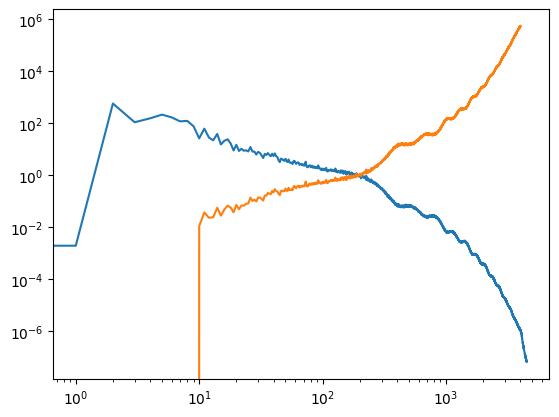

In [ ]:
plt.loglog(hp.alm2cl(tlmcodedel))
plt.loglog(hp.alm2cl(tlmcode))

In [6]:
k = qe_key

In [7]:
def camb_clfile_gradient_npy(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.
    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.
    """
    cols = np.load(fname).transpose()
    ell = np.arange(cols.shape[1])
    #print(cols.shape, ell)
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'pperp', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'pperp', 'te']):
        cls[k][ell[idc]] = np.nan_to_num(cols[i][idc] / w[idc])
    return cls

In [8]:
clgrads = [camb_clfile_gradient_npy(f"cls_grad_websky_{i}.npy") for i in range(4)]

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_38473/2649584772.py:16: RuntimeWarning: invalid value encountered in divide
  cls[k][ell[idc]] = np.nan_to_num(cols[i][idc] / w[idc])


In [9]:
Resps = [qresp.get_response(k, lmax_ivf, 'p', cls_weight = delcls_fid[i], cls_cmb = clgrads[i], fal = {'e': fel, 'b': fbl, 't':fals[i]["tt"]}, lmax_qlm=lmax_qlm)[0] for i in range(4)]

In [10]:
simidx = 0
mf0 = 0.

libdir_iterators = lambda qe_key, simidx, version: opj(TEMP,'%s_sim%04d'%(qe_key, simidx) + version)

libdir_iterator = libdir_iterators('ptt', simidx, '')

tr = int(os.environ.get('OMP_NUM_THREADS', 8))
cpp = np.copy(delcls_fid[index]['pp'][:lmax_qlm + 1])
cpp[:Lmin] *= 0.


path_plm0 = opj(libdir_iterator, 'phi_plm_it000.npy')
path_plm0_QE_norm = opj(libdir_iterator, 'normalized_phi_plm_it000.npy')
if not os.path.exists(path_plm0):
    print("New plm0")
    # We now build the Wiener-filtered QE here since not done already
    plm0  = qlms_dd.get_sim_qlm(k, int(simidx))  #Unormalized quadratic estimate:
    plm0 -= mf0  # MF-subtracted unnormalized QE
    # Isotropic normalization of the QE
    #NOTE: RESPONSE OF CMB. Here I am using the grad-lensed response
    R = Resps[index] #qresp.get_response(k, lmax_ivf, 'p', cls_weight = cls_len, cls_cmb = cls_grad, fal = {'e': fel, 'b': fbl, 't':ftl}, lmax_qlm=lmax_qlm)[0]
    # Isotropic Wiener-filter (here assuming for simplicity N0 ~ 1/R)
    WF = cpp * utils.cli(cpp + utils.cli(R))

    plm0 = alm_copy(plm0,  None, lmax_qlm, mmax_qlm) # Just in case the QE and MAP mmax'es were not consistent
    almxfl(plm0, utils.cli(R), mmax_qlm, True) # Normalized QE
    np.save(path_plm0_QE_norm, plm0)
    almxfl(plm0, WF, mmax_qlm, True)           # Wiener-filter QE
    almxfl(plm0, cpp > 0, mmax_qlm, True)
    np.save(path_plm0, plm0)

plm0 = np.load(path_plm0)

New plm0
Reading delensed tlm
Filtering
Transform to map
Noise index is 0
Setting noise sim to zero!


In [11]:
import matplotlib.pyplot as plt

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_38473/3919471706.py:2: RuntimeWarning: invalid value encountered in divide
  plt.loglog(R_/Resps[0], label = i)


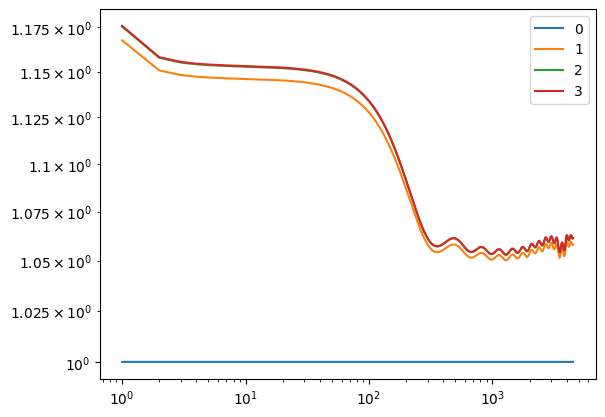

In [12]:
for i, R_ in enumerate(Resps):
    plt.loglog(R_/Resps[0], label = i)
plt.legend()


In [13]:
RQE = qresp.get_response(k, lmax_ivf, 'p', cls_weight = cls_len, cls_cmb = cls_grad, fal = {'e': fel, 'b': fbl, 't':ftl}, lmax_qlm=lmax_qlm)[0]
# Isotropic Wiener-filter (here assuming for simplicity N0 ~ 1/R)
cppQE = np.copy(delcls_fid[0]['pp'][:lmax_qlm + 1])
cppQE[:Lmin] *= 0.
WFQE = cppQE * utils.cli(cppQE + utils.cli(RQE))

In [14]:
np.savetxt("WFQE.txt", WFQE)

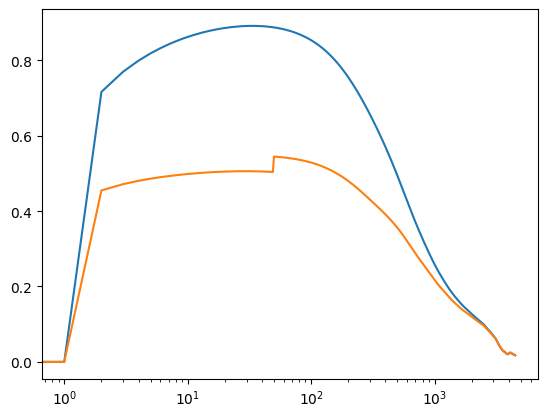

In [15]:
plt.plot(WFQE)
plt.plot(WF)
plt.xscale("log")

In [16]:
for i, d in enumerate(delcls_fid):
    np.savetxt(f"pp_{i}.txt", d["pp"])

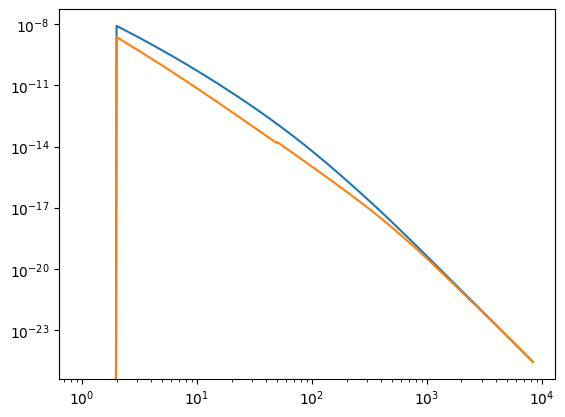

In [17]:
plt.loglog(delcls_fid[0]["pp"])
plt.loglog(delcls_fid[1]["pp"])

In [18]:
file = "/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecs/ptt_sim0000/normalized_phi_plm_it000.npy"

plmQE = np.load(file)
plmQEWiener = np.load("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecs/ptt_sim0000/phi_plm_it000.npy")

plmin = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/plm_in_0_lmax5120.fits")

In [19]:
lmax = hp.Alm.getlmax(plmQE.size)
plmin = utils.alm_copy(plmin, lmax)

In [20]:
residualin = hp.almxfl(plmin, (1-WFQE))

In [21]:
file = "/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecs_delensed/ptt_sim0000/normalized_phi_plm_it000.npy"

plmdelQE = np.load(file)
plmdelQEWiener = np.load("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecs_delensed/ptt_sim0000/phi_plm_it000.npy")

In [22]:
clQE = hp.alm2cl(plmQE)
clQEWiener = hp.alm2cl(plmQEWiener)
clDelQE = hp.alm2cl(plmdelQE)
clDelQEWiener = hp.alm2cl(plmdelQEWiener)
clin = hp.alm2cl(plmin)

clQEin = hp.alm2cl(plmin, plmQE)
clQEWienerin = hp.alm2cl(residualin, plmQEWiener)

clDelQEin = hp.alm2cl(residualin, plmdelQE)
clDelQEWienerin = hp.alm2cl(plmin, plmdelQEWiener)

clinresidual = hp.alm2cl(residualin)

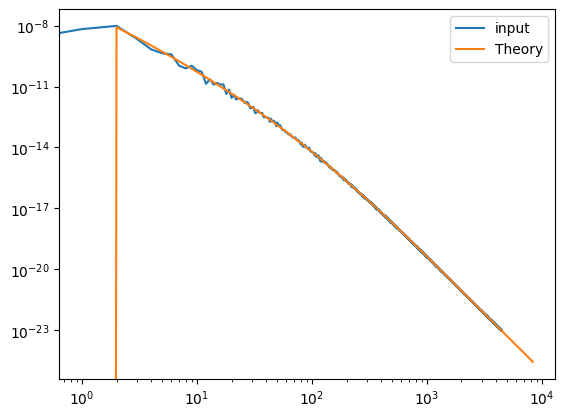

In [23]:
plt.loglog(clin, label = "input")
plt.plot(delcls_fid[0]["pp"], label = "Theory")
plt.legend()

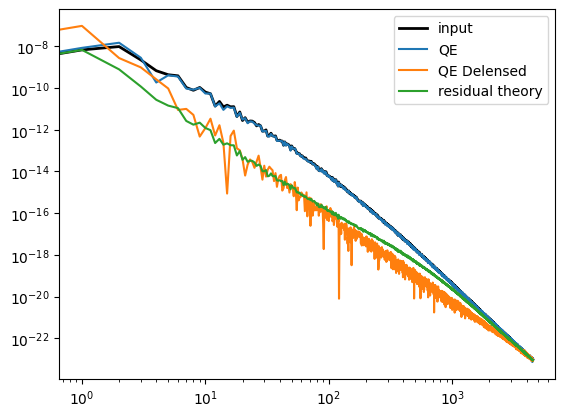

In [29]:
plt.loglog(clin, label = "input", color = "black", lw = 2)
plt.loglog(clQEin, label = "QE")

plt.loglog(abs(clDelQEin), label = "QE Delensed")

#plt.loglog(clDelQE, label = "del QE")
#plt.loglog(clDelQEWiener, label = "del QE Wiener")
plt.loglog(clinresidual, label = "residual theory")
plt.legend()

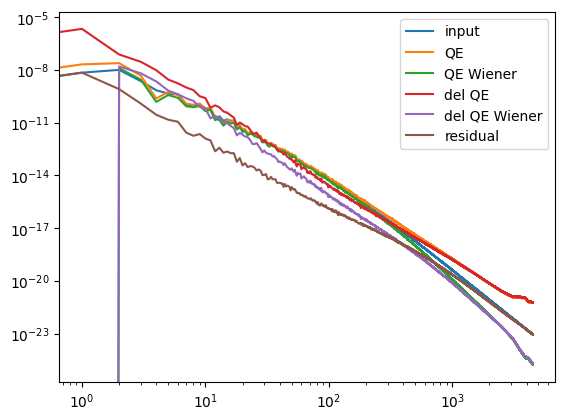

In [25]:
plt.loglog(clin, label = "input")
plt.loglog(clQE, label = "QE")
plt.loglog(clQEWiener, label = "QE Wiener")
plt.loglog(clDelQE, label = "del QE")
plt.loglog(clDelQEWiener, label = "del QE Wiener")
plt.loglog(clinresidual, label = "residual")
plt.legend()